In [77]:
#NDWI load packages

import datacube

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.dask import create_local_dask_cluster
from dea_tools.plotting import rgb



In [78]:
# Import tools to mask data for cloud

import scipy.ndimage
import xarray
import numpy
from datacube.utils.masking import make_mask
from datacube.utils.masking import mask_invalid_data
from odc.algo import mask_cleanup

import sys
sys.path.insert(1, '../Tools/')


import rasterio
import xarray as xr

In [79]:
# connect to datacube

dc = datacube.Datacube(app="07_Parallel_processing_with_Dask")

In [80]:
#Enable Dask

client = create_local_dask_cluster(return_client=True)



/env/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35761 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/akjournalism@gmail.com/proxy/35761/status,
Dashboard: /user/akjournalism@gmail.com/proxy/35761/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34545,Workers: 1
Dashboard: /user/akjournalism@gmail.com/proxy/35761/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:44667,Total threads: 2
Dashboard: /user/akjournalism@gmail.com/proxy/39837/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:44513,


In [81]:
# Lazy load data LANDSAT

lazy_ds_Land = dc.load(product=["ga_ls8c_ard_3",
                  "ga_ls9c_ard_3"],
                  measurements=["nbart_green", "nbart_swir_2", "oa_fmask"],
                       #crs = "EPSG:3577",
                  x=(149.34, 149.85),
                  y=(-37.5, -37.0),
                       output_crs="EPSG:7856",
                  time=('2020-02-07', '2020-02-28'),
                  dask_chunks={"time": 1, "x": 2048, "y": 2048})
resampling={
                   "fmask": "nearest",
                   "*": "bilinear"
               },


lazy_ds_Land

<xarray.Dataset>
Dimensions:       (time: 4, y: 1905, x: 1576)
Coordinates:
  * time          (time) datetime64[ns] 2020-02-10T23:44:57.745417 ... 2020-0...
  * y             (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.843e+06 5.843e+06
  * x             (x) float64 1.743e+05 1.743e+05 ... 2.215e+05 2.215e+05
    spatial_ref   int32 7856
Data variables:
    nbart_green   (time, y, x) int16 dask.array<chunksize=(1, 1905, 1576), meta=np.ndarray>
    nbart_swir_2  (time, y, x) int16 dask.array<chunksize=(1, 1905, 1576), meta=np.ndarray>
    oa_fmask      (time, y, x) uint8 dask.array<chunksize=(1, 1905, 1576), meta=np.ndarray>
Attributes:
    crs:           EPSG:7856
    grid_mapping:  spatial_ref

In [82]:
# Lazy load data SENTINEL

lazy_ds_Sent = dc.load(product=["'ga_s2am_ard_3", "ga_s2bm_ard_3"],
                  measurements=["nbart_green", "nbart_swir_2", "oa_fmask"],
                  x=(149.34, 149.85),
                  y=(-37.5, -37.0),
                       output_crs="EPSG:7856",
                  time=('2020-02-07', '2020-02-28'),
                  resolution=(-30, 30),
                  dask_chunks={"time": 1, "x": 2048, "y": 2048})
resampling={
                   "fmask": "nearest",
                   "*": "bilinear"
               },
    
  
lazy_ds_Sent

<xarray.Dataset>
Dimensions:       (time: 8, y: 1905, x: 1576)
Coordinates:
  * time          (time) datetime64[ns] 2020-02-14T00:06:52.104184 ... 2020-0...
  * y             (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.843e+06 5.843e+06
  * x             (x) float64 1.743e+05 1.743e+05 ... 2.215e+05 2.215e+05
    spatial_ref   int32 7856
Data variables:
    nbart_green   (time, y, x) int16 dask.array<chunksize=(1, 1905, 1576), meta=np.ndarray>
    nbart_swir_2  (time, y, x) int16 dask.array<chunksize=(1, 1905, 1576), meta=np.ndarray>
    oa_fmask      (time, y, x) uint8 dask.array<chunksize=(1, 1905, 1576), meta=np.ndarray>
Attributes:
    crs:           EPSG:7856
    grid_mapping:  spatial_ref

In [83]:
dc_measurements = dc.list_measurements()
dc_measurements.loc[['ga_s2bm_ard_3']]

name    dtype  \
product       measurement                                                       
ga_s2bm_ard_3 nbart_coastal_aerosol            nbart_coastal_aerosol    int16   
              nbart_blue                                  nbart_blue    int16   
              nbart_green                                nbart_green    int16   
              nbart_red                                    nbart_red    int16   
              nbart_red_edge_1                      nbart_red_edge_1    int16   
              nbart_red_edge_2                      nbart_red_edge_2    int16   
              nbart_red_edge_3                      nbart_red_edge_3    int16   
              nbart_nir_1                                nbart_nir_1    int16   
              nbart_nir_2                                nbart_nir_2    int16   
              nbart_swir_2                              nbart_swir_2    int16   
              nbart_swir_3                              nbart_swir_3    int16   
              oa_fmask                                      oa_fmask    uint8   
              oa_nbart_contiguity                oa_nbart_contiguity    uint8   
              oa_azimuthal_exiting              oa_azimuthal_exiting  float32   
              oa_azimuthal_incident            oa_azimuthal_incident  float32   
              oa_combined_terrain_shadow  oa_combined_terrain_shadow    uint8   
              oa_exiting_angle                      oa_exiting_angle  float32   
              oa_incident_angle                    oa_incident_angle  float32   
              oa_relative_azimuth                oa_relative_azimuth  float32   
              oa_relative_slope                    oa_relative_slope  float32   
              oa_satellite_azimuth              oa_satellite_azimuth  float32   
              oa_satellite_view                    oa_satellite_view  float32   
              oa_solar_azimuth                      oa_solar_azimuth  float32   
              oa_solar_zenith                        oa_solar_zenith  float32   
              oa_time_delta                            oa_time_delta  float32   
              oa_s2cloudless_mask                oa_s2cloudless_mask    uint8   
              oa_s2cloudless_prob                oa_s2cloudless_prob  float64   

                                         units nodata  \
product       measurement                               
ga_s2bm_ard_3 nbart_coastal_aerosol          1   -999   
              nbart_blue                     1   -999   
              nbart_green                    1   -999   
              nbart_red                      1   -999   
              nbart_red_edge_1               1   -999   
              nbart_red_edge_2               1   -999   
              nbart_red_edge_3               1   -999   
              nbart_nir_1                    1   -999   
              nbart_nir_2                    1   -999   
              nbart_swir_2                   1   -999   
              nbart_swir_3                   1   -999   
              oa_fmask                       1      0   
              oa_nbart_contiguity            1    255   
              oa_azimuthal_exiting           1    NaN   
              oa_azimuthal_incident          1    NaN   
              oa_combined_terrain_shadow     1    255   
              oa_exiting_angle               1    NaN   
              oa_incident_angle              1    NaN   
              oa_relative_azimuth            1    NaN   
              oa_relative_slope              1    NaN   
              oa_satellite_azimuth           1    NaN   
              oa_satellite_view              1    NaN   
              oa_solar_azimuth               1    NaN   
              oa_solar_zenith                1    NaN   
              oa_time_delta                  1    NaN   
              oa_s2cloudless_mask            1      0   
              oa_s2cloudless_prob            1    NaN   

                                                            

In [84]:
dc_measurements = dc.list_measurements()
dc_measurements.loc[['ga_ls8c_ard_3']]

name    dtype  \
product       measurement                                                       
ga_ls8c_ard_3 nbart_coastal_aerosol            nbart_coastal_aerosol    int16   
              nbart_blue                                  nbart_blue    int16   
              nbart_green                                nbart_green    int16   
              nbart_red                                    nbart_red    int16   
              nbart_nir                                    nbart_nir    int16   
              nbart_swir_1                              nbart_swir_1    int16   
              nbart_swir_2                              nbart_swir_2    int16   
              nbart_panchromatic                  nbart_panchromatic    int16   
              oa_fmask                                      oa_fmask    uint8   
              oa_nbart_contiguity                oa_nbart_contiguity    uint8   
              oa_azimuthal_exiting              oa_azimuthal_exiting  float32   
              oa_azimuthal_incident            oa_azimuthal_incident  float32   
              oa_combined_terrain_shadow  oa_combined_terrain_shadow    uint8   
              oa_exiting_angle                      oa_exiting_angle  float32   
              oa_incident_angle                    oa_incident_angle  float32   
              oa_relative_azimuth                oa_relative_azimuth  float32   
              oa_relative_slope                    oa_relative_slope  float32   
              oa_satellite_azimuth              oa_satellite_azimuth  float32   
              oa_satellite_view                    oa_satellite_view  float32   
              oa_solar_azimuth                      oa_solar_azimuth  float32   
              oa_solar_zenith                        oa_solar_zenith  float32   
              oa_time_delta                            oa_time_delta  float32   

                                         units nodata  \
product       measurement                               
ga_ls8c_ard_3 nbart_coastal_aerosol          1   -999   
              nbart_blue                     1   -999   
              nbart_green                    1   -999   
              nbart_red                      1   -999   
              nbart_nir                      1   -999   
              nbart_swir_1                   1   -999   
              nbart_swir_2                   1   -999   
              nbart_panchromatic             1   -999   
              oa_fmask                       1      0   
              oa_nbart_contiguity            1    255   
              oa_azimuthal_exiting           1    NaN   
              oa_azimuthal_incident          1    NaN   
              oa_combined_terrain_shadow     1    255   
              oa_exiting_angle               1    NaN   
              oa_incident_angle              1    NaN   
              oa_relative_azimuth            1    NaN   
              oa_relative_slope              1    NaN   
              oa_satellite_azimuth           1    NaN   
              oa_satellite_view              1    NaN   
              oa_solar_azimuth               1    NaN   
              oa_solar_zenith                1    NaN   
              oa_time_delta                  1    NaN   

                                                                                    aliases  \
product       measurement                                                                     
ga_ls8c_ard_3 nbart_coastal_aerosol                         [nbart_band01, coastal_aerosol]   
              nbart_blue                                               [nbart_band02, blue]   
              nbart_green                                             [nbart_band03, green]   
              nbart_red                                                 [nbart_band04, red]   
              nbart_nir                               [nbart_band05, nir, nbart_common_nir]   
              nbart_swir_1                [nbart_band06, swir_1, nbart_common_swir_1,

In [85]:
# Merge XArrays

import xarray as xr
import pandas as pd


# Merge the XArrays
merged_xarr = xr.concat([lazy_ds_Land, lazy_ds_Sent], dim='time',)


# Print the merged XArray
print(merged_xarr)

#merged_dim = 2 below could be a problem

<xarray.Dataset>
Dimensions:       (time: 12, y: 1905, x: 1576)
Coordinates:
  * time          (time) datetime64[ns] 2020-02-10T23:44:57.745417 ... 2020-0...
  * y             (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.843e+06 5.843e+06
  * x             (x) float64 1.743e+05 1.743e+05 ... 2.215e+05 2.215e+05
    spatial_ref   int32 7856
Data variables:
    nbart_green   (time, y, x) int16 dask.array<chunksize=(1, 1905, 1576), meta=np.ndarray>
    nbart_swir_2  (time, y, x) int16 dask.array<chunksize=(1, 1905, 1576), meta=np.ndarray>
    oa_fmask      (time, y, x) uint8 dask.array<chunksize=(1, 1905, 1576), meta=np.ndarray>
Attributes:
    crs:           EPSG:7856
    grid_mapping:  spatial_ref


In [86]:
# app

dc = datacube.Datacube(app="Masking_data")

# flags

merged_xarr.oa_fmask.attrs["flags_definition"]

{'fmask': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
  'values': {'0': 'nodata',
   '1': 'valid',
   '2': 'cloud',
   '3': 'shadow',
   '4': 'snow',
   '5': 'water'},
  'description': 'Fmask'}}

In [87]:

merged_xarr.oa_fmask


<xarray.DataArray 'oa_fmask' (time: 12, y: 1905, x: 1576)>
dask.array<concatenate, shape=(12, 1905, 1576), dtype=uint8, chunksize=(1, 1905, 1576), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2020-02-10T23:44:57.745417 ... 2020-02...
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.843e+06 5.843e+06
  * x            (x) float64 1.743e+05 1.743e+05 ... 2.215e+05 2.215e+05
    spatial_ref  int32 7856
Attributes:
    units:             1
    nodata:            0
    flags_definition:  {'fmask': {'bits': [0, 1, 2, 3, 4, 5, 6, 7], 'values':...
    crs:               EPSG:7856
    grid_mapping:      spatial_ref

In [88]:
dataset = xr.Dataset(merged_xarr)

In [89]:
merged_xarr


<xarray.Dataset>
Dimensions:       (time: 12, y: 1905, x: 1576)
Coordinates:
  * time          (time) datetime64[ns] 2020-02-10T23:44:57.745417 ... 2020-0...
  * y             (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.843e+06 5.843e+06
  * x             (x) float64 1.743e+05 1.743e+05 ... 2.215e+05 2.215e+05
    spatial_ref   int32 7856
Data variables:
    nbart_green   (time, y, x) int16 dask.array<chunksize=(1, 1905, 1576), meta=np.ndarray>
    nbart_swir_2  (time, y, x) int16 dask.array<chunksize=(1, 1905, 1576), meta=np.ndarray>
    oa_fmask      (time, y, x) uint8 dask.array<chunksize=(1, 1905, 1576), meta=np.ndarray>
Attributes:
    crs:           EPSG:7856
    grid_mapping:  spatial_ref

In [90]:
import numpy as np
import dask.array as da

def make_mask(variable, **flags):
    mask = da.zeros_like(variable, dtype=bool)
    mask_value = True

    for flag_name, flag_value in flags.items():
        mask |= variable == flag_value

    return mask == mask_value

In [91]:
# Create the mask based on "valid" pixels

clear_mask = make_mask(merged_xarr.oa_fmask, fmask="valid")

# Apply the mask

clear = merged_xarr.where(clear_mask)


In [92]:
# Plot
#clear_mask.plot(col="time", col_wrap=4)

In [93]:
# Identify pixels that are either "valid", "water" or "snow"

cloud_free_mask = (
    make_mask(merged_xarr.oa_fmask, fmask="valid") | 
    make_mask(merged_xarr.oa_fmask, fmask="water") | 
    make_mask(merged_xarr.oa_fmask, fmask="snow")
)

# Apply the mask
cloud_free = merged_xarr.where(cloud_free_mask)

In [94]:
# Set invalid nodata pixels to NaN

valid_data = merged_xarr.oa_fmask.plot
valid_data

# Identify pixels that are either "cloud" or "cloud_shadow"

cloud_shadow_mask = (
    make_mask(merged_xarr.oa_fmask, fmask="cloud") | 
    make_mask(merged_xarr.oa_fmask, fmask="shadow")
)

In [95]:
# Plot cloud shadow mask

#cloud_shadow_mask.plot(col="time", col_wrap=4)

In [96]:
# Dilate all cloud and cloud shadow pixels by 5 pixels in all directions

cloud_shadow_buffered = mask_cleanup(mask=cloud_shadow_mask,
                                     mask_filters=[("dilation", 5)])

In [97]:
# Plot cloud shadow buffered

#cloud_shadow_buffered.plot(col="time", col_wrap=4)

In [98]:
# Apply the mask

buffered_cloud_free = merged_xarr.where(~cloud_shadow_buffered)

# Set invalid nodata pixels to NaN

valid_data = mask_invalid_data(buffered_cloud_free)

valid_data

<xarray.Dataset>
Dimensions:       (time: 12, y: 1905, x: 1576)
Coordinates:
  * time          (time) datetime64[ns] 2020-02-10T23:44:57.745417 ... 2020-0...
  * y             (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.843e+06 5.843e+06
  * x             (x) float64 1.743e+05 1.743e+05 ... 2.215e+05 2.215e+05
    spatial_ref   int32 7856
Data variables:
    nbart_green   (time, y, x) float64 dask.array<chunksize=(1, 1905, 1576), meta=np.ndarray>
    nbart_swir_2  (time, y, x) float64 dask.array<chunksize=(1, 1905, 1576), meta=np.ndarray>
    oa_fmask      (time, y, x) float64 dask.array<chunksize=(1, 1905, 1576), meta=np.ndarray>
Attributes:
    crs:           EPSG:7856
    grid_mapping:  spatial_ref

In [99]:
#obs_pixels_count = valid_data.count(dim='time', skipnan=True)
#import numpy as np

#def count_nan_values(array):
#nan_count = np.isnan(valid_data).sum(dim = time) 
#return nan_count

# Count NaN values in the array
#nan_count = count_nan_values(valid_data)
#print("Number of NaN values:", nan_count)

In [100]:
#nan_count

In [101]:
#nan_count.attrs = valid_data.attrs

In [102]:
# calc mNDWI

band_diff = valid_data.nbart_green - valid_data.nbart_swir_2
band_sum = valid_data.nbart_green + valid_data.nbart_swir_2

valid_data["mndwi"] = band_diff / band_sum

valid_data

<xarray.Dataset>
Dimensions:       (time: 12, y: 1905, x: 1576)
Coordinates:
  * time          (time) datetime64[ns] 2020-02-10T23:44:57.745417 ... 2020-0...
  * y             (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.843e+06 5.843e+06
  * x             (x) float64 1.743e+05 1.743e+05 ... 2.215e+05 2.215e+05
    spatial_ref   int32 7856
Data variables:
    nbart_green   (time, y, x) float64 dask.array<chunksize=(1, 1905, 1576), meta=np.ndarray>
    nbart_swir_2  (time, y, x) float64 dask.array<chunksize=(1, 1905, 1576), meta=np.ndarray>
    oa_fmask      (time, y, x) float64 dask.array<chunksize=(1, 1905, 1576), meta=np.ndarray>
    mndwi         (time, y, x) float64 dask.array<chunksize=(1, 1905, 1576), meta=np.ndarray>
Attributes:
    crs:           EPSG:7856
    grid_mapping:  spatial_ref

In [103]:
## MAYBE APLLY MASKS TO DATA SET AGAIN AFTER CALLING INSTEAD OF DELETING 
#TRY NAN HERE
#no_nan = valid_data.where(buffered_cloud_free, cloud_shadow_buffered, cloud_free, clear_mask)
# del buffered_cloud_free, cloud_shadow_buffered, cloud_free, clear_mask

In [104]:
# Call lazy data XArray from Dask 

mndwi_load = valid_data.mndwi.load()
mndwi_load

<xarray.DataArray 'mndwi' (time: 12, y: 1905, x: 1576)>
array([[[        nan,         nan,         nan, ...,  0.10951526,
          0.10427561,  0.09947947],
        [        nan,         nan,         nan, ...,  0.10903427,
          0.1048864 ,  0.09953434],
        [        nan,         nan,         nan, ...,  0.13697219,
          0.13226837,  0.11945594],
        ...,
        [        nan,         nan,         nan, ...,  0.16293473,
          0.16943916,  0.17489208],
        [        nan,         nan,         nan, ...,  0.17283951,
          0.16920106,  0.17514256],
        [        nan,         nan,         nan, ...,  0.1822351 ,
          0.18035543,  0.17870285]],

       [[        nan,         nan,         nan, ..., -0.29934924,
         -0.30277186, -0.22041763],
        [        nan,         nan,         nan, ..., -0.28354978,
         -0.28111588, -0.2037037 ],
        [        nan,         nan,         nan, ..., -0.28216216,
         -0.28066528, -0.22954545],
...
        [-0.41801903, -0.38366718, -0.39323574, ...,  0.05611547,
          0.04168811, -0.04906227],
        [-0.45545657, -0.38906414, -0.41176471, ...,  0.14212166,
          0.07314219,  0.05857295],
        [-0.42901716, -0.44739639, -0.41948718, ...,  0.23053574,
          0.2130442 ,  0.17906761]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.41769317, -0.39265391, -0.39152371, ...,         nan,
                 nan,         nan],
        [-0.44709141, -0.40350877, -0.4151436 , ...,         nan,
                 nan,         nan],
        [-0.41662364, -0.45018647, -0.42064715, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * time         (time) datetime64[ns] 2020-02-10T23:44:57.745417 ... 2020-02...
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.843e+06 5.843e+06
  * x            (x) float64 1.743e+05 1.743e+05 ... 2.215e+05 2.215e+05
    spatial_ref  int32 7856

In [105]:
#obs_pixels_count = valid_data.count(dim='time', skipnan=True)
#import numpy as np

#def count_nan_values(mndwi_load):
    #nan_count = np.isnan(mndwi_load).sum()
    #return nan_count

# Count NaN values in the array
#nan_count = count_nan_values(mndwi_load)
#print("Number of NaN values:", nan_count)

In [106]:
#nan_count

In [107]:
# plot data 

#mndwi_load.plot()

# Display the plot
#plt.show()

# mndwi_load.mndwi.plot(col='time', col_wrap=5)

#import xarray as xr
#import matplotlib.pyplot as plt

# Assuming you have a dataset named 'ds' with a variable named 'variable1'
# Access the variable and plot it
#mndwi_load['mndwi'].plot()

# Display the plot
#plt.show()

In [108]:
#ds_ignorenan

In [109]:
#remove nan before calc - what if we made it a reallllly big number so it stands out.... 

In [110]:
valid_data.mndwi

<xarray.DataArray 'mndwi' (time: 12, y: 1905, x: 1576)>
array([[[        nan,         nan,         nan, ...,  0.10951526,
          0.10427561,  0.09947947],
        [        nan,         nan,         nan, ...,  0.10903427,
          0.1048864 ,  0.09953434],
        [        nan,         nan,         nan, ...,  0.13697219,
          0.13226837,  0.11945594],
        ...,
        [        nan,         nan,         nan, ...,  0.16293473,
          0.16943916,  0.17489208],
        [        nan,         nan,         nan, ...,  0.17283951,
          0.16920106,  0.17514256],
        [        nan,         nan,         nan, ...,  0.1822351 ,
          0.18035543,  0.17870285]],

       [[        nan,         nan,         nan, ..., -0.29934924,
         -0.30277186, -0.22041763],
        [        nan,         nan,         nan, ..., -0.28354978,
         -0.28111588, -0.2037037 ],
        [        nan,         nan,         nan, ..., -0.28216216,
         -0.28066528, -0.22954545],
...
        [-0.41801903, -0.38366718, -0.39323574, ...,  0.05611547,
          0.04168811, -0.04906227],
        [-0.45545657, -0.38906414, -0.41176471, ...,  0.14212166,
          0.07314219,  0.05857295],
        [-0.42901716, -0.44739639, -0.41948718, ...,  0.23053574,
          0.2130442 ,  0.17906761]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.41769317, -0.39265391, -0.39152371, ...,         nan,
                 nan,         nan],
        [-0.44709141, -0.40350877, -0.4151436 , ...,         nan,
                 nan,         nan],
        [-0.41662364, -0.45018647, -0.42064715, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * time         (time) datetime64[ns] 2020-02-10T23:44:57.745417 ... 2020-02...
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.843e+06 5.843e+06
  * x            (x) float64 1.743e+05 1.743e+05 ... 2.215e+05 2.215e+05
    spatial_ref  int32 7856

In [111]:
# Extract the NDWI data variable COULD BE WRONG WORKS WITHOUT
ndwi_variable = valid_data.mndwi

threshold = 0.05  # Adjust as per your requirement

# Create a boolean array with null, true, and false values
bool_data = xr.where(np.isnan(ndwi_variable), np.nan, ndwi_variable > threshold)

# Create an Xarray DataArray from the boolean array
#bool_3 = xr.DataArray(bool_data, dims=('x', 'y'))



# Create a binary water or no water raster
#binary_data = ndwi_variable > threshold if == (nan) leave it nan) 3 LEVEL bOOLEAN

#binary_data = binary_date.dtype('uint8')

In [112]:
bool_data.attrs = valid_data.attrs

In [113]:
bool_data

<xarray.DataArray 'mndwi' (time: 12, y: 1905, x: 1576)>
array([[[nan, nan, nan, ...,  1.,  1.,  1.],
        [nan, nan, nan, ...,  1.,  1.,  1.],
        [nan, nan, nan, ...,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, ...,  1.,  1.,  1.],
        [nan, nan, nan, ...,  1.,  1.,  1.],
        [nan, nan, nan, ...,  1.,  1.,  1.]],

       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  1.,  0.,  0.],
        [ 0.,  0.,  0., ...,  1.,  1.,  1.],
        [ 0.,  0.,  0., ...,  1.,  1.,  1.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]]])
Coordinates:
  * time         (time) datetime64[ns] 2020-02-10T23:44:57.745417 ... 2020-02...
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.843e+06 5.843e+06
  * x            (x) float64 1.743e+05 1.743e+05 ... 2.215e+05 2.215e+05
    spatial_ref  int32 7856
Attributes:
    crs:           EPSG:7856
    grid_mapping:  spatial_ref

In [114]:
# Calculate total wetness through time
wet_pixels_sum = bool_data.sum(dim=['time'])

In [115]:
wet_pixels_sum.attrs = valid_data.attrs

In [116]:
wet_pixels_sum

<xarray.DataArray 'mndwi' (y: 1905, x: 1576)>
array([[2., 2., 2., ..., 2., 1., 1.],
       [2., 2., 2., ..., 1., 1., 1.],
       [2., 2., 2., ..., 1., 1., 2.],
       ...,
       [0., 0., 0., ..., 3., 1., 1.],
       [0., 0., 0., ..., 3., 2., 2.],
       [0., 0., 0., ..., 3., 2., 2.]])
Coordinates:
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.843e+06 5.843e+06
  * x            (x) float64 1.743e+05 1.743e+05 ... 2.215e+05 2.215e+05
    spatial_ref  int32 7856
Attributes:
    crs:           EPSG:7856
    grid_mapping:  spatial_ref

In [117]:
# Calculate total count wet pixels **** CHECK WORKS ****
wet_pixels_count = bool_data.count(dim=['time'])

#wet_pixels_count

In [118]:
#et_pixels_count.attrs = valid_data.attrs

wet_pixels_count

<xarray.DataArray 'mndwi' (y: 1905, x: 1576)>
array([[5, 5, 5, ..., 6, 6, 6],
       [5, 5, 5, ..., 6, 6, 6],
       [5, 5, 5, ..., 6, 6, 6],
       ...,
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5]])
Coordinates:
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.843e+06 5.843e+06
  * x            (x) float64 1.743e+05 1.743e+05 ... 2.215e+05 2.215e+05
    spatial_ref  int32 7856

In [119]:
wet_pixels = wet_pixels_sum/wet_pixels_count

In [120]:
wet_pixels.attrs = valid_data.attrs

In [121]:
wet_pixels

<xarray.DataArray 'mndwi' (y: 1905, x: 1576)>
array([[0.4       , 0.4       , 0.4       , ..., 0.33333333, 0.16666667,
        0.16666667],
       [0.4       , 0.4       , 0.4       , ..., 0.16666667, 0.16666667,
        0.16666667],
       [0.4       , 0.4       , 0.4       , ..., 0.16666667, 0.16666667,
        0.33333333],
       ...,
       [0.        , 0.        , 0.        , ..., 0.6       , 0.2       ,
        0.2       ],
       [0.        , 0.        , 0.        , ..., 0.6       , 0.4       ,
        0.4       ],
       [0.        , 0.        , 0.        , ..., 0.6       , 0.4       ,
        0.4       ]])
Coordinates:
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.843e+06 5.843e+06
  * x            (x) float64 1.743e+05 1.743e+05 ... 2.215e+05 2.215e+05
    spatial_ref  int32 7856
Attributes:
    crs:           EPSG:7856
    grid_mapping:  spatial_ref

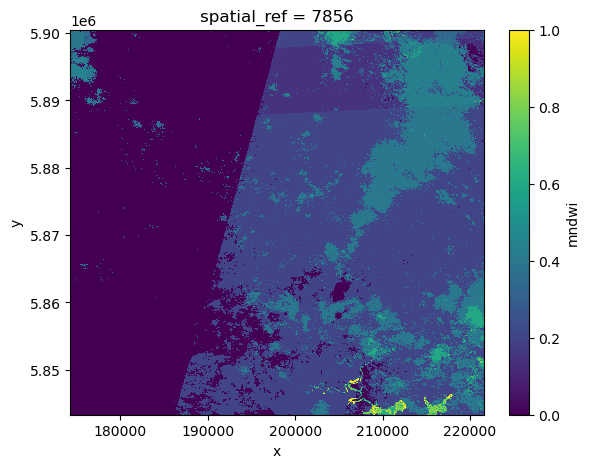

In [122]:
#not necessary
wet_pixels.plot(size=5,)

In [123]:
#wet_pixels = wo.isel(time=-0).to_array()

from datacube.utils.cog import write_cog

write_cog (geo_im=wet_pixels,
          fname='./mndwi_GDA_1',
          overwrite=True)

PosixPath('mndwi_GDA_1')

In [124]:
#CLOSE DASK

client.close()

# delete stored objects

del valid_data, wet_pixels


/env/lib/python3.8/site-packages/dask/core.py:119: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.8/site-packages/dask/core.py:119: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.8/site-packages/dask/core.py:119: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.8/site-packages/dask/core.py:119: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.8/site-packages/dask/core.py:119: FutureWarning: el